# Data Processing - Chapter 4

In [1]:
import pandas as pd
from io import StringIO

csv_data = '''
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0'''

df = pd.read_csv(StringIO(csv_data))
df



,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


For larger DataFrame, we can use `isnull()` method to return a DataFrame with boolean values that indiciate whether a cell contains a numberic vlaue (False) or if data is missing (True)

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

It is recommended to use NumPy arrays when possible, as most scikit-learn function support DataFrame objects as inputs, since NumPy array handling is more mature in the library.

## Eliminating training examples or features with missing values

In [3]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


One of the easiest ways to deal with missing data is to remove rows or columns containing missing values.

In [4]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


Drop columns that have a t lesat one `NaN` value in any row by setting `axis=1`

In [5]:
# Only drops rows where all columns are NaN
# (returns the whole array here since we don't have a row iwth all values NaN)

df.dropna(how="all")

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# drop rows that have fewer than 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# only drop rows where NaN appera in specific columns (here: 'C')
df.dropna(subset=["C"])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputing missing values

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)

imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Each `NaN` value is the corresponding mean, which is separately calculated for each feature column.

<br/> You can also use `median` or `most_frequent` as the strategy. Useful for categorical features. 

In [9]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


More convenient way -> `fillna` method and providing an imputation method as an arguement

## Categorical data encoding with pandas

In [10]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class2'],
    ['red', 'L', 13.5, 'class1'],
    ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


- ordinal feature (colour and size)
- nominal feature (price)

## Mapping ordinal features

In [11]:
size_mapping = {'XL': 3, 'L': 2, 'M': 1}

df['size'] = df['size'].map(size_mapping)

df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [12]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

Inverse mapping so that we can get back to string

## Encoding class labels

In [13]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}

class_mapping

{'class1': 0, 'class2': 1}

In [14]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [15]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


Reverse key-value pairs in the mapping dictionary. Converts class labels back to original string representations.

In [16]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()

y = class_le.fit_transform(df['classlabel'].values)

y

array([1, 0, 1])

Scikit-learn alternative `LabelEncoder`

In [17]:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

`fit_transform` method is just a shortcut for calling `fit` and `transform` separately.
<br />

`inverse_transform` method to transform the integer class labels back into their original string representation.

## One-hot encoding on nominal features

In [18]:
X = df[['color','size','price']].values

color_le = LabelEncoder()

X[:, 0] = color_le.fit_transform(X[:, 0])

X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

Nominal `color` column with `LabelEncoder`
<br/>

First column of NumPy array X, holds the new color values
- blue = 0
- green = 1
- red = 2

Common classification models, such as the ones covered in the previous chapters, will now assume that green is larger than blue, and red is larger than green.

In [19]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values

color_ohe = OneHotEncoder()

color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

- Convert `color` feature into three new features: blue, green, and red.
- Binary values can be encoded as 0 and 1. (E.g. blue=1, green=0, red=0)

In [20]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values

c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])

c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [21]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


Convenient way to create dummy features via one-hot encoding is to use `get_dummies()`.

In [22]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


Can drop blue because feature information is still preserved since `color_green=0` and `color_red=0`, it still implies that the observed object is blue.

In [23]:
color_ohe = OneHotEncoder(categories='auto', drop='first')

c_transf = ColumnTransformer(transformers=[
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1,2])
])

c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

In order to drop a redundant column via the OneHotEncoder, we need to set `drop='first'` and set
`categories='auto'`

## Encoding ordinal features

In [24]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']

df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


If we are unsure about the numerical differences between the categories of ordinal features, or differences between two ordinal values is not defined, we can also encode them using a threshold encoding with 0/1 values.

In [25]:
df['x > M'] = df['size'].apply(
    lambda x: 1 if x in {'L', 'XL'} else 0
)
df['x > L'] = df['size'].apply(
    lambda x: 1 if x == 'XL' else 0
)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


## Partitioning training and test datasets

In [26]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [27]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

Convenient way to randomly partition a dataset into separate test and training datasets = `train_test_split`
<br/>

First NumPy array = features.
- Variable `X` and assigned the class labels from the first column to variable `y`.
- `test_size=0.3` = assigned 30 percent of wine examples to `X_test` and `y_test`. Remaining 70 percent of wine examples to `X_train` and `y_train`.
- `stratify=y` = ensures that the class distribution in the training and test sets is similar to the original dataset.

### Min-max Scaling

`MinMaxScaler` from Scikit-learn

In [28]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [29]:

ex = np.array([0, 1, 2, 3, 4, 5])

# standardize
print('standardized:', (ex - ex.mean()) / ex.std())

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


`StandardScaler` using Scikit-learn

In [30]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [31]:

from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


`l1` = pentalty parameter to obtain sprase solution

In [33]:
lr.intercept_

array([-1.26333165, -1.21605841, -2.37009311])

In [34]:
lr.coef_

array([[ 1.24532452,  0.1811331 ,  0.7422797 , -1.16030751,  0.        ,
         0.        ,  1.17600977,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54192016,  2.51115373],
       [-1.53726425, -0.38732851, -0.99532933,  0.36518037, -0.05940929,
         0.        ,  0.66812238,  0.        ,  0.        , -1.93432671,
         1.23302513,  0.        , -2.23106117],
       [ 0.13595656,  0.16826644,  0.35725293,  0.        ,  0.        ,
         0.        , -2.4379397 ,  0.        ,  0.        ,  1.56350083,
        -0.81906869, -0.49251272,  0.        ]])

- `intecept_` - bias unit
- `coef_` - weights

Since we fit the LogisticRegression object on a multiclass dataset via the one-versus-rest (OvR) approach, the first intercept belongs to the model that fits class 1 versus classes 2 and 3, the second value is the intercept of the model that fits class 2 versus classes 1 and 3, and the third value is the intercept of the model that fits class 3 versus classes 1 and 2

This is the old version and it's deprecated. The new version is below.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

base_lr = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear'  # still valid for L1
)

lr = OneVsRestClassifier(base_lr)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))


Training accuracy: 1.0
Test accuracy: 1.0


In [36]:
intercepts = [estimator.intercept_ for estimator in lr.estimators_]
print(intercepts)

[array([-1.26350645]), array([-1.21577471]), array([-2.37157662])]


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/lib/python3

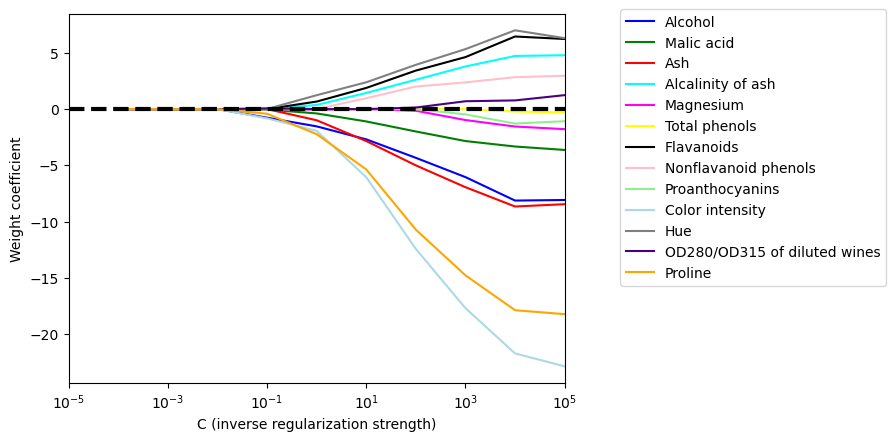

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

plt.savefig('figures/04_01.png', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)

plt.show()

### Sequential Backward Selection (SBS)

In [38]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

`k_features` - specify the desired number of features we want to return
`accuracy_score` - evalutate the performance of a model (estimator for classification)
<br/>

while loop:
- `fit` - created with `itertools.combinations` function - evaluated and reduced until feature subset has the desired dimensionality
- `self.scores_` - stores the accuracy scores for each feature subset, based on `X_test` - later used to evaluate results
- `self.indices_` - we can use `transform` method to return a new data arrya with the selected feature columns

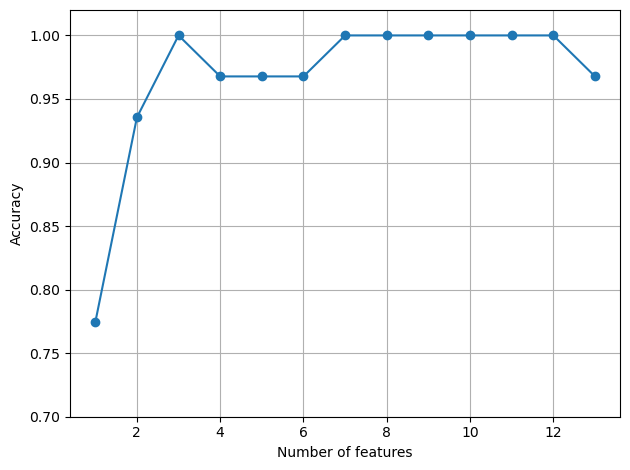

In [39]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

plt.tight_layout()
plt.savefig('04_02.png', dpi=300)
plt.show()

- SBS implementation already splits the datasets into test and training dataset, but we can still feed `X_train` to algorithm.
- SBS `fit` method will create new training subsets for testing (validation) and training, which is why this test set is called teh **validation dataset**.
- This approach prevents the original test set from becoming a part of the training process.
- SBS collects the scores of the best feature subset at each stage.

In [40]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [41]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))


Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [42]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


When using less than a quarter of the original features in the Wine dataset, the prediction accruacy on the test datasets declined slightly.

 1)- Proline                        0.185453
 2)- Flavanoids                     0.174751
 3)- Color intensity                0.143920
 4)- OD280/OD315 of diluted wines   0.136162
 5)- Alcohol                        0.118529
 6)- Hue                            0.058739
 7)- Total phenols                  0.050872
 8)- Magnesium                      0.031357
 9)- Malic acid                     0.025648
10)- Proanthocyanins                0.025570
11)- Alcalinity of ash              0.022366
12)- Nonflavanoid phenols           0.013354
13)- Ash                            0.013279


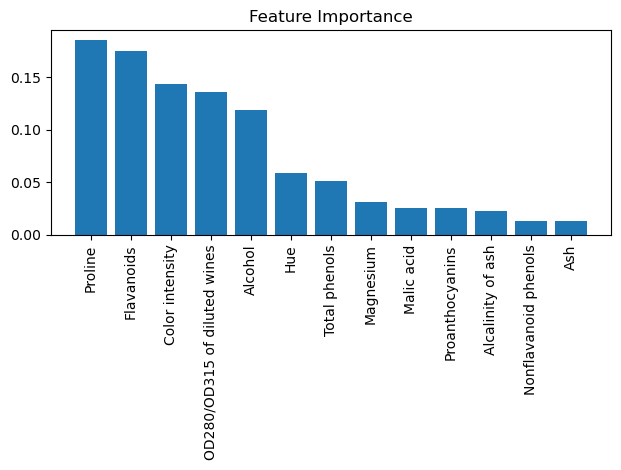

In [44]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_

indicies = np.argsort(importances)[::-1]

for f in range(X_train. shape[1]):
    print("%2d)- %-*s %f" % (f + 1, 30, feat_labels[indicies[f]], importances[indicies[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indicies], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indicies], rotation=90)
plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.savefig('figures/04_03.png', dpi=300)
plt.show()

Train forest of 500 trees on Wine dataset and rank the 13 features by their respective importance measures.

In [46]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)

print('Number of features that meet this threshold', 'criterion:', X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print("2%d) %-*s %f" % (f + 1, 30, feat_labels[indicies[f]], importances[indicies[f]]))

Number of features that meet this threshold criterion: 5
21) Proline                        0.185453
22) Flavanoids                     0.174751
23) Color intensity                0.143920
24) OD280/OD315 of diluted wines   0.136162
25) Alcohol                        0.118529
